#Packages Install and Import


In [ ]:
!pip install imbalanced-learn
!pip install --upgrade pandas
!pip install optuna
!pip install xgboost
!pip install python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 61.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.2.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
import pickle
import optuna
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

#Load Data and Check Null Values

In [ ]:
# Load Data
dataset = pd.read_csv("zero_div_recent_years.csv")
num_dataset = dataset.select_dtypes(include=[np.number])
# Null value analysis
dataset.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4004 entries, 0 to 4003
Data columns (total 179 columns):
 #    Column                                                Non-Null Count  Dtype  
---   ------                                                --------------  -----  
 0    year                                                  4004 non-null   int64  
 1    adjDividend                                           4004 non-null   float64
 2    dps_growth                                            4004 non-null   float64
 3    dps_growth_rate                                       4004 non-null   float64
 4    industry                                              4004 non-null   object 
 5    sector                                                4004 non-null   object 
 6    companyRating                                         4004 non-null   float64
 7    companyRating_percentage_change                       4004 non-null   float64
 8    companyRating_actual_change                   

#Multivariate Analysis

In [ ]:
# Correlation matrix
correlation_matrix = num_dataset.corr()

def rank_columns_by_correlation(df, threshold):
    # Calculating correlation matrix
    corr_matrix = df.corr()
    # Initializing a list to hold the tuples (col1, col2, correlation)
    correlations = []
    # Iterating over the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):  # avoiding duplicate and self-correlation
            # Including only correlations above the specified threshold
            if abs(corr_matrix.iloc[i, j]) > threshold:
                correlations.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

    # Sorting the list by absolute correlation in descending order
    sorted_correlations = sorted(correlations, key=lambda x: abs(x[2]), reverse=True)
    correlation_df = pd.DataFrame(sorted_correlations, columns=['Column1', 'Column2', 'Correlation'])
    return correlation_df

top_correlations = rank_columns_by_correlation(num_dataset, 0.95)

# Remove highly correlated columns
columns_to_remove = top_correlations["Column2"].unique()
dataset.drop(columns_to_remove, axis="columns", inplace=True)

#Train-Test Split

In [ ]:
# Data Separation by Year
training_data = dataset.loc[dataset["year"] < 2021]
validation_data = dataset[dataset['year'] == 2021]
testing_data = dataset.loc[dataset["year"] == 2022]


# Predictor - Target Split
X_train = training_data.drop("dps_change_next_year", axis="columns")
y_train = training_data["dps_change_next_year"]
X_test = testing_data.drop("dps_change_next_year", axis="columns")
y_test = testing_data["dps_change_next_year"]
X_validate = validation_data.drop("dps_change_next_year", axis="columns")
y_validate = validation_data["dps_change_next_year"]

#Data Pre-Processing, Encode Categorical Features, Normalize Feature Values

In [ ]:
# Define categorical and other columns
categorical_columns = ["industry", "sector", "symbol"]
other_columns = [col for col in X_train.columns if col not in categorical_columns]

# Preprocessing: Label encoding and Scaling
column_transformer = ColumnTransformer(
    transformers=[
        ('categorical', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_columns)
    ],
    remainder='passthrough'
)

# Standard scaling within a pipeline to prevent data leakage
pipeline_preprocess = Pipeline([
    ('transformer', column_transformer),
    ('scaler', StandardScaler())
])

X_train_transformed = pipeline_preprocess.fit_transform(X_train)
X_validate_transformed = pipeline_preprocess.transform(X_validate)
X_test_transformed = pipeline_preprocess.transform(X_test)

# Note: after transformation, the output will be a numpy array and column orders will be changed.
X_train_transformed = pd.DataFrame(X_train_transformed, columns=categorical_columns + other_columns)
X_validate_transformed = pd.DataFrame(X_validate_transformed, columns=categorical_columns + other_columns)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=categorical_columns + other_columns)

# Check our data type
X_train_transformed.info(verbose=True, show_counts=True)

# Let's change our data types back to their original forms - However, this time, categorical variables have become
# number like strings
cols_to_convert = {'industry': 'str', 'sector': 'str', 'symbol': 'str', 'year': 'int'}
X_train_transformed = X_train_transformed.astype(cols_to_convert)
X_validate_transformed = X_validate_transformed.astype(cols_to_convert)
X_test_transformed = X_test_transformed.astype(cols_to_convert)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2912 entries, 0 to 2911
Data columns (total 126 columns):
 #    Column                                                Non-Null Count  Dtype  
---   ------                                                --------------  -----  
 0    industry                                              2912 non-null   float64
 1    sector                                                2912 non-null   float64
 2    symbol                                                2912 non-null   float64
 3    year                                                  2912 non-null   float64
 4    adjDividend                                           2912 non-null   float64
 5    dps_growth                                            2912 non-null   float64
 6    dps_growth_rate                                       2912 non-null   float64
 7    companyRating                                         2912 non-null   float64
 8    companyRating_percentage_change               

#Check Data Imbalanced

In [ ]:
training_data_transformed = pd.concat([X_train_transformed, y_train], axis=1)
training_data_transformed["dps_change_next_year"].value_counts()

dps_change_next_year
constant/increased    2749
decreased              163
Name: count, dtype: int64

#Stratified Cross-Validation and Smote Oversampling

In [ ]:
# Stratified Cross-Validation Setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Perform oversampling using SMOTE
categorical_indices = [X_train_transformed.columns.get_loc(col) for col in categorical_columns]
smote = SMOTENC(random_state=1, categorical_features=categorical_indices)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train_transformed, y_train)
# Check our training data
pd.DataFrame(y_train_oversampled)["dps_change_next_year"].value_counts()
X_train_oversampled.info()
y_train_oversampled.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5498 entries, 0 to 5497
Columns: 126 entries, industry to enterpriseValueMultiple_percentage_change
dtypes: float64(122), int64(1), object(3)
memory usage: 5.3+ MB


dps_change_next_year
constant/increased    2749
decreased             2749
Name: count, dtype: int64

#Feature Selection

feature 0's importance score: 0.00972442832778787 (industry)
feature 1's importance score: 0.0047842642899228825 (sector)
feature 2's importance score: 0.0106060993607627 (symbol)
feature 3's importance score: 0.0006472697314549086 (year)
feature 4's importance score: 0.024412589264846813 (adjDividend)
feature 5's importance score: 0.06317848076297915 (dps_growth)
feature 6's importance score: 0.11369299857061936 (dps_growth_rate)
feature 7's importance score: 0.03185085052081901 (companyRating)
feature 8's importance score: 0.008619708144506239 (companyRating_percentage_change)
feature 9's importance score: 0.04420537100597874 (companyRating_actual_change)
feature 10's importance score: 0.01412962109231536 (interestRate)
feature 11's importance score: 0.007145134982793356 (interestRate_percentage_change)
feature 12's importance score: 0.004475718378408989 (interestRate_actual_change)
feature 13's importance score: 0.010698072699868865 (inflationRate)
feature 14's importance score: 0.0

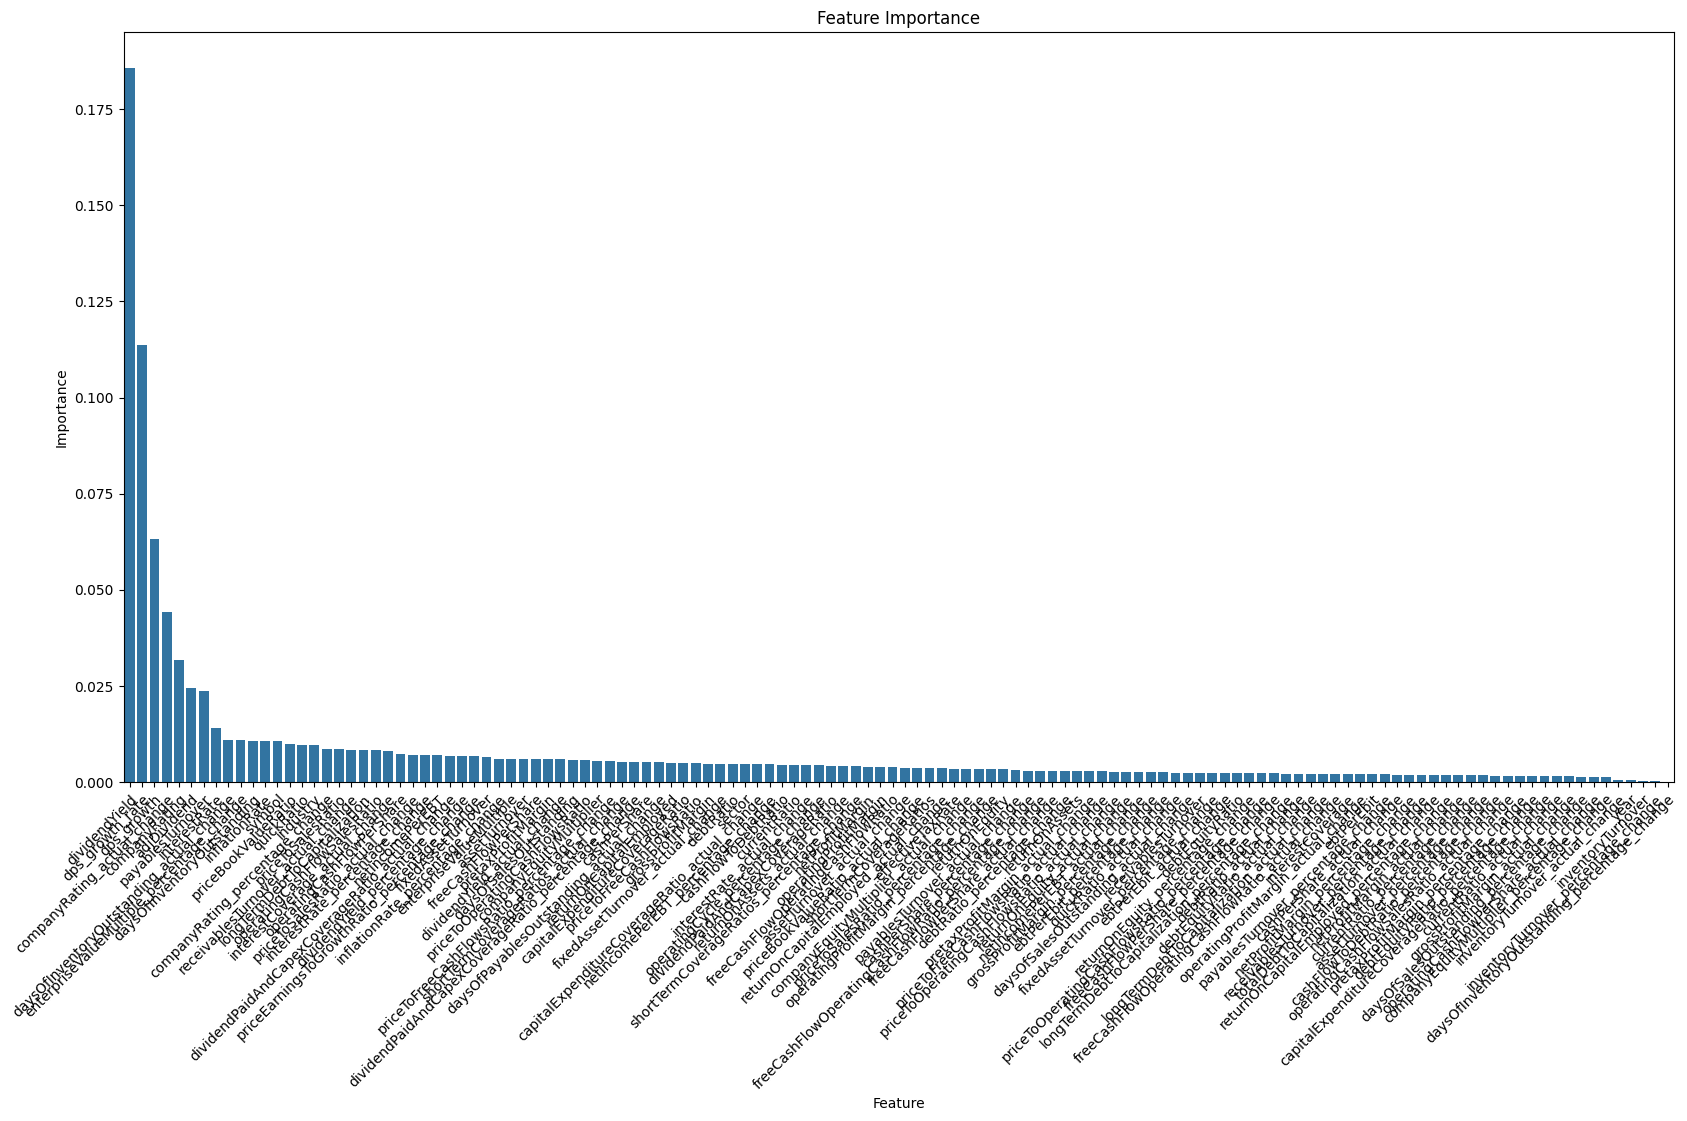

In [ ]:
# Feature importance analysis - Tree Based
randomForestModel = RandomForestClassifier(max_features=None)  # We want all features to be considered for each tree
randomForestModel.fit(X_train_oversampled, y_train_oversampled)
model_importance = randomForestModel.feature_importances_
importance_table = pd.DataFrame(columns=["Feature", "Importance"])  # Create an importance table to plot bar chart
featureNum = 0
for score in model_importance:
    print("feature " + str(featureNum) + "'s importance score: " + str(score) + " (" + X_train_oversampled.columns[featureNum] + ")")
    rowAdded = pd.DataFrame([[X_train_oversampled.columns[featureNum], score]], columns=["Feature", "Importance"])
    importance_table = pd.concat([importance_table, rowAdded])
    featureNum = featureNum + 1
importance_table.sort_values('Importance', inplace=True, ascending=False)


# Plot a bar chart to visualize feature importance
plt.figure(figsize=(20, 10))
sns.barplot(data=importance_table, x="Feature", y="Importance")
plt.title("Feature Importance")
plt.subplots_adjust(bottom=0.2, top=0.95)
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
plt.savefig('feature.png')
plt.show()

#Feature Engineering(Random Forest + Backward Stepwise Selection)

In [ ]:
# Sort importance_table by Importance in ascending order to start with the least important
importance_table_sorted = importance_table.sort_values('Importance')

# Initialize variables to track the best feature set and its AUC score
best_auc_score = 0
best_feature_set = X_train_oversampled.columns.tolist()

# Initialize the result dataframe
result_df = pd.DataFrame(columns=['Features_Removed', 'ROC_Score', 'Remaining_Features'])

X_train_reduced = X_train_oversampled
X_validate_reduced = X_validate_transformed

# Loop through features, starting from the least important
for index, row in importance_table_sorted.iterrows():
    # Drop the feature from training and test data
    X_train_reduced = X_train_reduced.drop(columns=[row['Feature']])
    X_validate_reduced = X_validate_reduced.drop(columns=[row['Feature']])

    # Train a random forest model
    randomForestModel = RandomForestClassifier(max_features=None)
    randomForestModel.fit(X_train_reduced, y_train_oversampled)

    # Predict probabilities on test data
    y_pred_probs = randomForestModel.predict_proba(X_validate_reduced)[:, 1]

    # Compute ROC score
    roc_score = roc_auc_score(y_validate, y_pred_probs)

    # Track the best performing feature set
    if roc_score > best_auc_score:
        best_auc_score = roc_score
        best_feature_set = X_train_reduced.columns.tolist()

    # Append the result to the result dataframe using pd.concat
    new_row = pd.DataFrame({
        'Features_Removed': [row['Feature']],
        'ROC_Score': [roc_score],
        'Remaining_Features': [", ".join(X_train_reduced.columns)]
    })
    result_df = pd.concat([result_df, new_row], ignore_index=True)

    print(f"Feature Removed: {row['Feature']}, ROC_AUC Score: {roc_score}")

    # If only one feature left, break the loop
    if X_train_reduced.shape[1] == 1:
        break

# Save the results to file for further analysis
result_df.to_pickle('result_df.pkl')

# Output the best feature set and its AUC score
print(f"Best AUC-ROC Score: {best_auc_score}")
print("Best Feature Set:", best_feature_set)

Feature Removed: daysOfInventoryOutstanding_percentage_change, ROC_AUC Score: 0.8240926456542503
Feature Removed: inventoryTurnover_percentage_change, ROC_AUC Score: 0.8374164278892072
Feature Removed: inventoryTurnover, ROC_AUC Score: 0.8361747851002866
Feature Removed: year, ROC_AUC Score: 0.8303247373447946
Feature Removed: inventoryTurnover_actual_change, ROC_AUC Score: 0.8323543457497613
Feature Removed: companyEquityMultiplier_percentage_change, ROC_AUC Score: 0.8251910219675264
Feature Removed: operatingCashFlowPerShare_actual_change, ROC_AUC Score: 0.8384670487106017
Feature Removed: daysOfSalesOutstanding_percentage_change, ROC_AUC Score: 0.8319245463228272
Feature Removed: grossProfitMargin_actual_change, ROC_AUC Score: 0.8323543457497613
Feature Removed: currentRatio_actual_change, ROC_AUC Score: 0.8394937917860554
Feature Removed: capitalExpenditureCoverageRatio_percentage_change, ROC_AUC Score: 0.8189828080229227
Feature Removed: debtEquityRatio_percentage_change, ROC_AUC 

In [ ]:
with open('best_features.pkl', 'w') as file:
    for string in best_feature_set:
        file.write(string + '\n')

In [ ]:
df = pd.read_pickle('result_df.pkl')

#Load Best Features

In [ ]:
# If the best feature set is 'None', use all features; otherwise, filter out the dataset
if best_feature_set != 'None':
    X_train_final = X_train_oversampled[best_feature_set]
    X_validate_final = X_validate_transformed[best_feature_set]
else:
    X_train_final = X_train_oversampled
    X_validate_final = X_validate_transformed

#Feature Importance Score revised



feature 0's importance score: 0.17036411085637757 (dps_growth)
feature 1's importance score: 0.21451287255561188 (dps_growth_rate)
feature 2's importance score: 0.16200708721992058 (companyRating)
feature 3's importance score: 0.155375357465842 (companyRating_actual_change)
feature 4's importance score: 0.2977405719022481 (dividendYield)


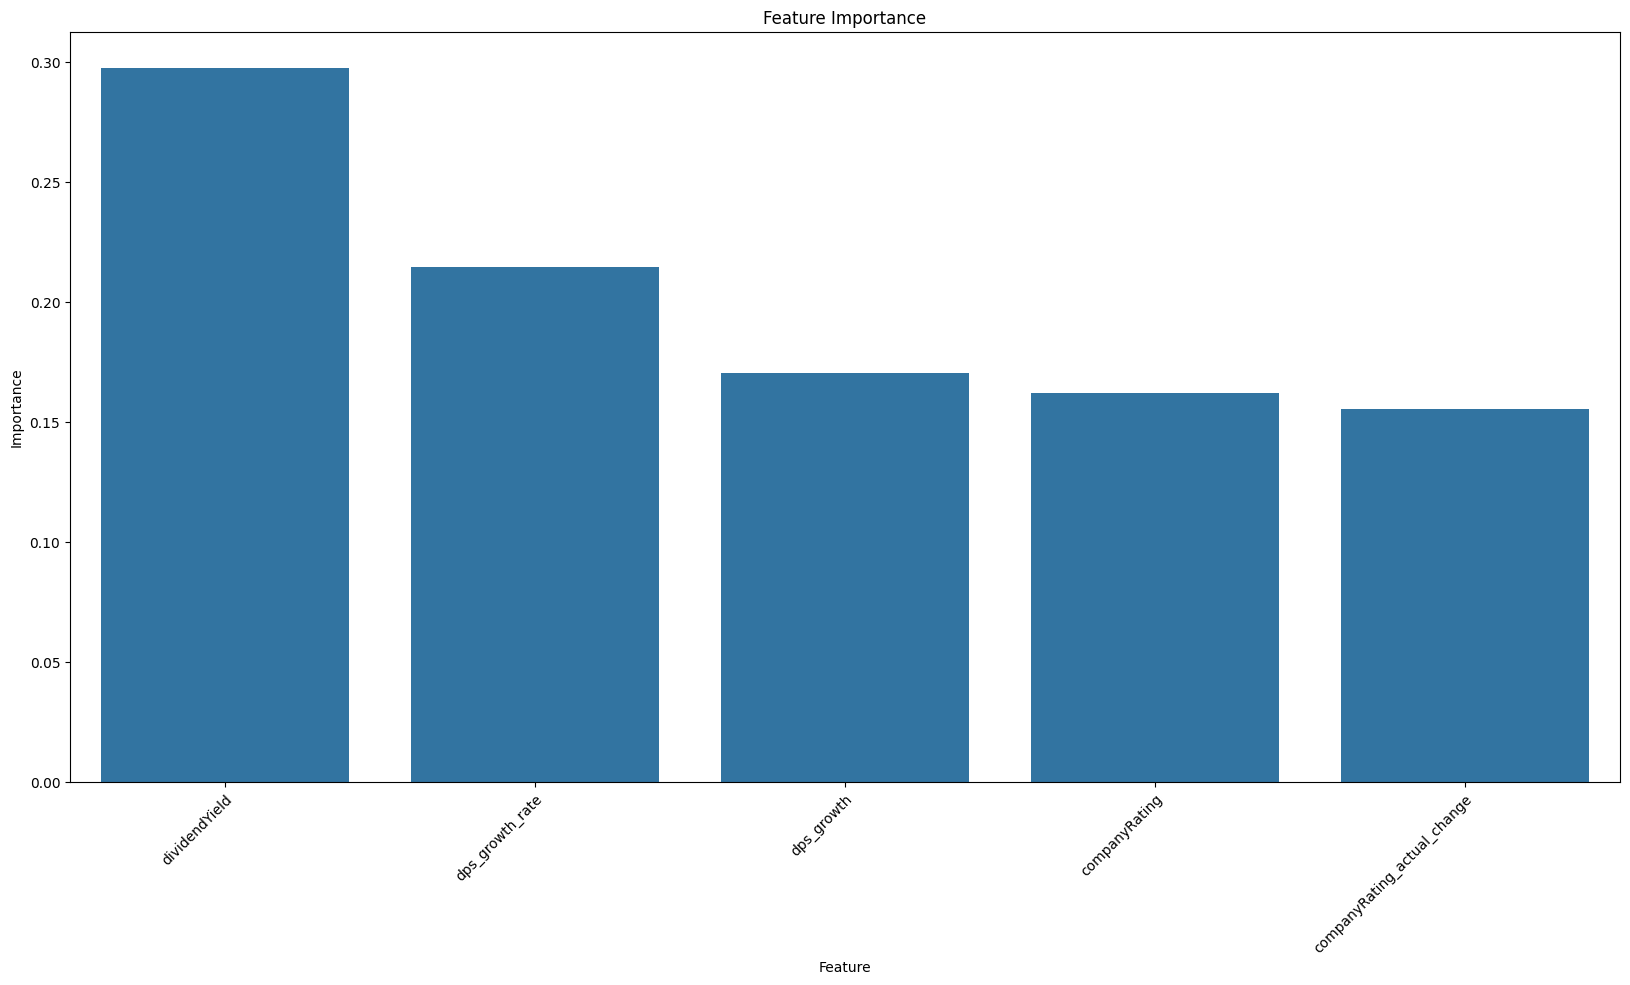

In [ ]:
# Feature importance analysis - Tree Based
randomForestModel = RandomForestClassifier(max_features=None)  # We want all features to be considered for each tree
randomForestModel.fit(X_train_final, y_train_oversampled)
model_importance = randomForestModel.feature_importances_
importance_table = pd.DataFrame(columns=["Feature", "Importance"])  # Create an importance table to plot bar chart
featureNum = 0
for score in model_importance:
    print("feature " + str(featureNum) + "'s importance score: " + str(score) + " (" + X_train_final.columns[featureNum] + ")")
    rowAdded = pd.DataFrame([[X_train_final.columns[featureNum], score]], columns=["Feature", "Importance"])
    importance_table = pd.concat([importance_table, rowAdded])
    featureNum = featureNum + 1
importance_table.sort_values('Importance', inplace=True, ascending=False)
# Plot a bar chart to visualize feature importance
plt.figure(figsize=(20, 10))
sns.barplot(data=importance_table, x="Feature", y="Importance")
plt.title("Feature Importance")
plt.subplots_adjust(bottom=0.2, top=0.95)
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
plt.savefig('feature.png')
plt.show()

#Model Training

##Logistic Regression

In [ ]:
# Bayesian Optimization with optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Suppress log messages

# Logistic Regression
def objective_function(trial):
    C = trial.suggest_float('C', 0.1, 10, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])

    model = LogisticRegression(
        C=C,
        penalty=penalty,
        solver='liblinear',
        n_jobs=-1
    )

    # Using cross_val_score to get the average precision score for each fold
    scores = cross_val_score(model, X_train_final, y_train_oversampled, cv=5, scoring='roc_auc')
    roc_auc = np.mean(scores)
    # Printing intermediate results
    print(f"Trial {trial.number}, C: {C}, penalty: {penalty}, ROC-AUC: {roc_auc}")
    return roc_auc


study_lr = optuna.create_study(direction="maximize")
study_lr.optimize(objective_function, n_trials=50)

best_params_lr = study_lr.best_params
print("Best Parameters: ", best_params_lr)
print("Best ROC-AUC Score: ", study_lr.best_value)

# Create and save model
best_model_lr = LogisticRegression(**best_params_lr, solver='liblinear', n_jobs=-1)
with open('best_models/lr.pkl', 'wb') as file:
    pickle.dump(best_model_lr, file)

Trial 0, C: 5.277294639316085, penalty: l1, ROC-AUC: 0.7618587604811152
Trial 1, C: 0.8555747232294454, penalty: l1, ROC-AUC: 0.7617601192250373
Trial 2, C: 4.28331964180228, penalty: l1, ROC-AUC: 0.7618508217796445
Trial 3, C: 0.11579525750464825, penalty: l2, ROC-AUC: 0.7615026461334657
Trial 4, C: 4.500565465228283, penalty: l1, ROC-AUC: 0.7618541323819417
Trial 5, C: 1.7699023068058093, penalty: l1, ROC-AUC: 0.7618336003853738
Trial 6, C: 7.491725352693377, penalty: l2, ROC-AUC: 0.7618667003868793
Trial 7, C: 0.7094171540364972, penalty: l2, ROC-AUC: 0.7618018503966641
Trial 8, C: 0.6353085640365084, penalty: l2, ROC-AUC: 0.7617879552605037
Trial 9, C: 0.3235312338099143, penalty: l2, ROC-AUC: 0.7617085128483042
Trial 10, C: 2.195704403023349, penalty: l2, ROC-AUC: 0.7618488371042768
Trial 11, C: 9.211504282544016, penalty: l1, ROC-AUC: 0.7618627310361439
Trial 12, C: 8.442339523798955, penalty: l1, ROC-AUC: 0.76185941802526
Trial 13, C: 9.423596403731494, penalty: l2, ROC-AUC: 0.7

##Decision Tree

In [ ]:


# Decision Tree
def objective_function(trial):
    max_depth = trial.suggest_int('max_depth', 1, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion
    )

    # Using cross_val_score to get the average precision score for each fold
    scores = cross_val_score(model, X_train_final, y_train_oversampled, cv=5, scoring='roc_auc')
    roc_auc = np.mean(scores)
    # Printing intermediate results
    print(f"Trial {trial.number}, max_depth: {max_depth}, min_samples_split: {min_samples_split}, "
          f"min_samples_leaf: {min_samples_leaf}, criterion: {criterion}, ROC-AUC: {roc_auc}")
    return roc_auc

study_dt = optuna.create_study(direction="maximize")
study_dt.optimize(objective_function, n_trials=50)

best_params_dt = study_dt.best_params
print("Best Parameters: ", best_params_dt)
print("Best ROC-AUC Score: ", study_dt.best_value)

# Create and save model
best_model_dt = DecisionTreeClassifier(**best_params_dt)
with open('best_models/dt.pkl', 'wb') as file:
    pickle.dump(best_model_dt, file)



Trial 0, max_depth: 6, min_samples_split: 5, min_samples_leaf: 9, criterion: entropy, ROC-AUC: 0.8993888801577624
Trial 1, max_depth: 9, min_samples_split: 10, min_samples_leaf: 2, criterion: gini, ROC-AUC: 0.9079298119797077
Trial 2, max_depth: 25, min_samples_split: 13, min_samples_leaf: 1, criterion: gini, ROC-AUC: 0.8967799328606482
Trial 3, max_depth: 36, min_samples_split: 7, min_samples_leaf: 9, criterion: gini, ROC-AUC: 0.9092259735958693
Trial 4, max_depth: 15, min_samples_split: 2, min_samples_leaf: 5, criterion: gini, ROC-AUC: 0.9018260259826281
Trial 5, max_depth: 29, min_samples_split: 2, min_samples_leaf: 11, criterion: entropy, ROC-AUC: 0.915724072317813
Trial 6, max_depth: 23, min_samples_split: 9, min_samples_leaf: 9, criterion: entropy, ROC-AUC: 0.91383333845158
Trial 7, max_depth: 16, min_samples_split: 8, min_samples_leaf: 1, criterion: entropy, ROC-AUC: 0.8911473808125969
Trial 8, max_depth: 13, min_samples_split: 3, min_samples_leaf: 1, criterion: gini, ROC-AUC: 0

##KNN

In [ ]:
# KNN
def objective_function(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_int('p', 1, 5)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])

    model = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        p=p,
        metric=metric
    )

    # Using cross_val_score to get the average precision score for each fold
    scores = cross_val_score(model, X_train_final, y_train_oversampled, cv=5, scoring='roc_auc')
    roc_auc = np.mean(scores)
    # Printing intermediate results
    print(f"Trial {trial.number}, n_neighbors: {n_neighbors}, weights: {weights}, p: {p}, metric: {metric}, "
          f"ROC-AUC: {roc_auc}")
    return roc_auc


study_knn = optuna.create_study(direction="maximize")
study_knn.optimize(objective_function, n_trials=50)

best_params_knn = study_knn.best_params
print("Best Parameters: ", best_params_knn)
print("Best ROC-AUC Score: ", study_knn.best_value)

# Create and save model
best_model_knn = KNeighborsClassifier(**best_params_knn)
with open('best_models/knn.pkl', 'wb') as file:
    pickle.dump(best_model_knn, file)

Trial 0, n_neighbors: 27, weights: uniform, p: 3, metric: minkowski, ROC-AUC: 0.888530680275181
Trial 1, n_neighbors: 30, weights: distance, p: 1, metric: manhattan, ROC-AUC: 0.9389335579340348
Trial 2, n_neighbors: 25, weights: distance, p: 1, metric: minkowski, ROC-AUC: 0.940816039380391
Trial 3, n_neighbors: 2, weights: distance, p: 3, metric: manhattan, ROC-AUC: 0.9226943106173507
Trial 4, n_neighbors: 29, weights: uniform, p: 3, metric: euclidean, ROC-AUC: 0.8949432994625841
Trial 5, n_neighbors: 16, weights: uniform, p: 2, metric: manhattan, ROC-AUC: 0.9241643505095667
Trial 6, n_neighbors: 28, weights: distance, p: 2, metric: minkowski, ROC-AUC: 0.9260684893645846
Trial 7, n_neighbors: 21, weights: uniform, p: 5, metric: minkowski, ROC-AUC: 0.8896835671167713
Trial 8, n_neighbors: 4, weights: uniform, p: 1, metric: minkowski, ROC-AUC: 0.929549366692258
Trial 9, n_neighbors: 22, weights: distance, p: 3, metric: manhattan, ROC-AUC: 0.9426274036941698
Trial 10, n_neighbors: 11, wei

##Random Forest

In [ ]:
# Random Forest
def objective_function(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 150)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        n_jobs=-1
    )

    # Using cross_val_score to get the average ROC-AUC score for each fold
    scores = cross_val_score(model, X_train_final, y_train_oversampled, cv=5, scoring='roc_auc')
    roc_auc = np.mean(scores)
    # Printing intermediate results
    print(f"Trial {trial.number}, n_estimators: {n_estimators}, max_depth: {max_depth}, "
          f"min_samples_split: {min_samples_split}, min_samples_leaf: {min_samples_leaf}, ROC-AUC: {roc_auc}")
    return roc_auc


study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_function, n_trials=50)

best_params_rf = study_rf.best_params
print("Best Parameters: ", best_params_rf)
print("Best ROC-AUC: Score: ", study_rf.best_value)

# Create and save model
best_model_rf = RandomForestClassifier(**best_params_rf, n_jobs=-1)
with open('best_models/rf.pkl', 'wb') as file:
    pickle.dump(best_model_rf, file)


Trial 0, n_estimators: 61, max_depth: 14, min_samples_split: 9, min_samples_leaf: 15, ROC-AUC: 0.9435912760992939
Trial 1, n_estimators: 140, max_depth: 9, min_samples_split: 12, min_samples_leaf: 12, ROC-AUC: 0.9442426825633383
Trial 2, n_estimators: 109, max_depth: 23, min_samples_split: 3, min_samples_leaf: 15, ROC-AUC: 0.9435862945400354
Trial 3, n_estimators: 139, max_depth: 24, min_samples_split: 9, min_samples_leaf: 13, ROC-AUC: 0.9460200261933794
Trial 4, n_estimators: 94, max_depth: 3, min_samples_split: 3, min_samples_leaf: 13, ROC-AUC: 0.8862412145297988
Trial 5, n_estimators: 128, max_depth: 20, min_samples_split: 14, min_samples_leaf: 14, ROC-AUC: 0.9448319288262657
Trial 6, n_estimators: 44, max_depth: 19, min_samples_split: 9, min_samples_leaf: 13, ROC-AUC: 0.9451596483463547
Trial 7, n_estimators: 140, max_depth: 19, min_samples_split: 11, min_samples_leaf: 13, ROC-AUC: 0.9455536184497735
Trial 8, n_estimators: 51, max_depth: 32, min_samples_split: 9, min_samples_leaf: 

##XgBoost

In [ ]:
# XgBoost
# It requires the target to be 0 and 1, and all features be numerical
# Encode our target
label_encoder = LabelEncoder()
# Fit the encoder and transform the target variable
y_train_oversampled_encoded = label_encoder.fit_transform(y_train_oversampled)

# Cast categorical types into numbers
# cols_to_convert = {'industry': 'float', 'sector': 'float', 'symbol': 'float'}
cols = ['industry', 'sector', 'symbol']
for i in cols:
  if i in X_train_final.columns:
    X_train_final = X_train_final[i].astype('float')
    X_validate_final = X_validate_final[i].astype('float')

# This suppresses printing logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective_function(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 150)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.9, log=True)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    gamma = trial.suggest_float('gamma', 0, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)

    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        use_label_encoder=False,
        n_jobs=-1
    )

    # Using cross_val_score to get the average ROC-AUC score for each fold
    scores = cross_val_score(model, X_train_final, y_train_oversampled_encoded, cv=5, scoring='roc_auc')
    roc_auc = np.mean(scores)
    # Printing intermediate results
    print(f"Trial {trial.number}, n_estimators: {n_estimators}, max_depth: {max_depth}, learning_rate: {learning_rate},"
          f"min_child_weight: {min_child_weight}, subsample: {subsample}, colsample_bytree: {colsample_bytree}, "
          f"gamma: {gamma}, reg_alpha: {reg_alpha}, reg_lambda: {reg_lambda}, ROC-AUC: {roc_auc}")
    return roc_auc


study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_function, n_trials=50)

best_params_xgb = study_xgb.best_params
print("Best Parameters: ", best_params_xgb)
print("Best ROC-AUC Score: ", study_xgb.best_value)

best_model_xgb = XGBClassifier(**best_params_xgb, use_label_encoder=False, n_jobs=-1)
with open('best_models/xgb.pkl', 'wb') as file:
    pickle.dump(best_model_xgb, file)


Trial 0, n_estimators: 26, max_depth: 26, learning_rate: 0.02304625948519757,min_child_weight: 7, subsample: 0.8093569916764264, colsample_bytree: 0.8542164752358279, gamma: 0.9142648185872841, reg_alpha: 0.3466856039123096, reg_lambda: 0.301059919295947, ROC-AUC: 0.9379706116304625
Trial 1, n_estimators: 39, max_depth: 23, learning_rate: 0.09403010190295437,min_child_weight: 7, subsample: 0.9897687543774976, colsample_bytree: 0.6132328097158117, gamma: 0.7019811223119126, reg_alpha: 0.18451123566887762, reg_lambda: 0.06059917541119453, ROC-AUC: 0.955808083818814
Trial 2, n_estimators: 111, max_depth: 37, learning_rate: 0.4214612792230851,min_child_weight: 9, subsample: 0.9855918476295322, colsample_bytree: 0.8826743607011296, gamma: 0.5825429037085453, reg_alpha: 0.6940906255278676, reg_lambda: 0.8646053965513903, ROC-AUC: 0.9599228903039334
Trial 3, n_estimators: 143, max_depth: 45, learning_rate: 0.036554480863957,min_child_weight: 6, subsample: 0.6411383818970533, colsample_bytree:

#Model Selection

In [ ]:
X_test_final = X_test_transformed[best_feature_set]
cols = ['industry', 'sector', 'symbol']
for i in cols:
  if i in X_test_final.columns:
    X_test_final = X_test_final[i].astype('float')

# Model selection - Compare Performance
with open('best_models/lr.pkl', 'rb') as file:
    best_model_lr = pickle.load(file)
with open('best_models/dt.pkl', 'rb') as file:
    best_model_dt = pickle.load(file)
with open('best_models/knn.pkl', 'rb') as file:
    best_model_knn = pickle.load(file)
with open('best_models/rf.pkl', 'rb') as file:
    best_model_rf = pickle.load(file)
with open('best_models/xgb.pkl', 'rb') as file:
    best_model_xgb = pickle.load(file)

print("Testing Performances...Please wait")
best_model_lr.fit(X_train_final, y_train_oversampled)
predicted_probs = best_model_lr.predict_proba(X_test_final)[:, 1]
lr_performance = roc_auc_score(y_test, predicted_probs)

best_model_dt.fit(X_train_final, y_train_oversampled)
predicted_probs = best_model_dt.predict_proba(X_test_final)[:, 1]
dt_performance = roc_auc_score(y_test, predicted_probs)

best_model_knn.fit(X_train_final, y_train_oversampled)
predicted_probs = best_model_knn.predict_proba(X_test_final)[:, 1]
knn_performance = roc_auc_score(y_test, predicted_probs)

best_model_rf.fit(X_train_final, y_train_oversampled)
predicted_probs = best_model_rf.predict_proba(X_test_final)[:, 1]
rf_performance = roc_auc_score(y_test, predicted_probs)

best_model_xgb.fit(X_train_final, y_train_oversampled_encoded)
predicted_probs = best_model_xgb.predict_proba(X_test_final)[:, 1]
xgb_performance = roc_auc_score(y_test, predicted_probs)


# Test performance of the models are
print(f"Logistic Regression Test ROCAUC: {lr_performance}")
print(f"Decision Tree Test ROCAUC: {dt_performance}")
print(f"KNN Test ROCAUC: {knn_performance}")
print(f"Random Forest Test ROCAUC: {rf_performance}")
print(f"XGBoost Test ROCAUC: {xgb_performance}")

Testing Performances...Please wait
Logistic Regression Test ROCAUC: 0.9585635359116023
Decision Tree Test ROCAUC: 0.4233425414364641
KNN Test ROCAUC: 0.4191988950276243
Random Forest Test ROCAUC: 0.6167127071823204
XGBoost Test ROCAUC: 0.6091160220994475
